In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from rich import pretty

from quantify_core.analysis.calibration import rotate_to_calibrated_axis
from quantify_core.analysis.fitting_models import exp_decay_func
from quantify_core.data import handling as dh
from quantify_core.utilities import dataset_examples
from quantify_core.utilities.dataset_examples import (
    mk_nested_mc_dataset,
    mk_shots_from_probabilities,
    mk_surface7_cyles_dataset,
)
from quantify_core.utilities.examples_support import (
    mk_iq_shots,
    mk_surface7_sched,
    round_trip_dataset,
)
from quantify_core.utilities.inspect_utils import display_source_code

pretty.install()

dh.set_datadir(Path.home() / "quantify-data")  # change me!

In [2]:
display_source_code(mk_surface7_sched)

def mk_surface7_sched ( num_cycles : int = 3 ): 
 """Generates a schedule with some of the feature of a Surface 7 experiment as 
 portrayed in Fig. 4b of :cite:`marques_logical_qubit_2021`. 

 Parameters 
 ---------- 
 num_cycles 
 The number of times to repeat the main cycle. 

 Returns 
 ------- 
 : 
 A schedule similar to a Surface 7 dance. 
 """ 

 from quantify_scheduler import Schedule 
 from quantify_scheduler.operations.gate_library import CZ , Y90 , Measure , Reset , X 

 sched = Schedule ( "S7 dance" ) 

 q_d1 , q_d2 , q_d3 , q_d4 = [ f "D { i } " for i in range ( 1 , 5 )] 
 q_a1 , q_a2 , q_a3 = [ f "A { i } " for i in range ( 1 , 4 )] 
 all_qubits = q_d1 , q_d2 , q_d3 , q_d4 , q_a1 , q_a2 , q_a3 

 sched . add ( Reset ( * all_qubits )) 

 for cycle in range ( num_cycles ): 
 sched . add ( Y90 ( q_d1 )) 
 for qubit in [ q_d2 , q_d3 , q_d4 ]: 
 sched . add ( Y90 ( qubit ), ref_pt = "start" , rel_time = 0 ) 
 sched . add ( Y90 ( q_a2 ), ref_pt = "start" , rel_time = 0 ) 

 for qubit in [ q_d2 , q_d1 , q_d4 , q_d3 ]: 
 sched . add ( CZ ( qC = qubit , qT = q_a2 )) 

 sched . add ( Y90 ( q_d1 )) 
 for qubit in [ q_d2 , q_d3 , q_d4 ]: 
 sched . add ( Y90 ( qubit ), ref_pt = "start" , rel_time = 0 ) 
 sched . add ( Y90 ( q_a2 ), ref_pt = "start" , rel_time = 0 ) 

 sched . add ( Y90 ( q_a1 ), ref_pt = "end" , rel_time = 0 ) 
 sched . add ( Y90 ( q_a3 ), ref_pt = "start" , rel_time = 0 ) 

 sched . add ( CZ ( qC = q_d1 , qT = q_a1 )) 
 sched . add ( CZ ( qC = q_d2 , qT = q_a3 )) 
 sched . add ( CZ ( qC = q_d3 , qT = q_a1 )) 
 sched . add ( CZ ( qC = q_d4 , qT = q_a3 )) 

 sched . add ( Y90 ( q_a1 ), ref_pt = "end" , rel_time = 0 ) 
 sched . add ( Y90 ( q_a3 ), ref_pt = "start" , rel_time = 0 ) 

 sched . add ( Measure ( q_a2 , acq_index = cycle )) 
 for qubit in ( q_a1 , q_a3 ): 
 sched . add ( Measure ( qubit , acq_index = cycle ), ref_pt = "start" , rel_time = 0 ) 

 for qubit in [ q_d1 , q_d2 , q_d3 , q_d4 ]: 
 sched . add ( X ( qubit ), ref_pt = "start" , rel_time = 0 ) 

 # final measurements 

 sched . add ( Measure ( * all_qubits [: 4 ], acq_index = 0 ), ref_pt = "end" , rel_time = 0 ) 

 return sched

In [3]:
# mock data parameters
num_shots = 128  # NB usually >~1000 in real experiments
ground = -0.2 + 0.65j
excited = 0.7 + 4j
centroids = ground, excited
sigmas = [0.1] * 2

display_source_code(mk_iq_shots)
display_source_code(mk_shots_from_probabilities)
display_source_code(mk_surface7_cyles_dataset)

def mk_iq_shots ( 
 num_shots : int = 128 , 
 sigmas : Union [ Tuple [ float ], np . ndarray ] = ( 0.1 , 0.1 ), 
 centers : Union [ Tuple [ complex ], np . ndarray ] = ( - 0.2 + 0.65 j , 0.7 + 4 j ), 
 probabilities : Union [ Tuple [ float ], np . ndarray ] = ( 0.4 , 0.6 ), 
 seed : Union [ int , None ] = 112233 , 
 ) -> np . ndarray : 
 """ 
 Generates clusters of (I + 1j*Q) points with a Gaussian distribution with the 
 specified sigmas and centers according to the probabilities of each cluster 

 .. admonition:: Examples 
 :class: dropdown 

 .. include:: examples/utilities.examples_support.mk_iq_shots.rst.txt 

 Parameters 
 ---------- 
 num_shots 
 The number of shot to generate. 
 sigma 
 The sigma of the Gaussian distribution used for both real and imaginary parts. 
 centers 
 The center of each cluster on the imaginary plane. 
 probabilities 
 The probabilities of each cluster being randomly selected for each shot. 
 seed 
 Random number generator seed passed to ``numpy.random.default_rng``. 
 """ 
 if not len ( sigmas ) == len ( centers ) == len ( probabilities ): 
 raise ValueError ( 
 f "Incorrect input. sigmas= { sigmas } , centers= { centers } and " 
 f "probabilities= { probabilities } must have the same length." 
 ) 

 rng = np . random . default_rng ( seed = seed ) 

 cluster_indices = tuple ( range ( len ( centers ))) 
 choices = rng . choice ( a = cluster_indices , size = num_shots , p = probabilities ) 

 shots = [] 
 for idx in cluster_indices : 
 num_shots_this_cluster = np . sum ( choices == idx ) 
 i_data = rng . normal ( 
 loc = centers [ idx ] . real , 
 scale = sigmas [ idx ], 
 size = num_shots_this_cluster , 
 ) 
 q_data = rng . normal ( 
 loc = centers [ idx ] . imag , 
 scale = sigmas [ idx ], 
 size = num_shots_this_cluster , 
 ) 
 shots . append ( i_data + 1 j * q_data ) 
 return np . concatenate ( shots )

def mk_shots_from_probabilities ( probabilities : Union [ np . ndarray , list ], ** kwargs ): 
 """Generates multiple shots for a list of probabilities assuming two states. 

 Parameters 
 ---------- 
 probabilities 
 The list/array of the probabilities of one of the states. 
 **kwargs 
 Keyword arguments passed to 
 :func:`~quantify_core.utilities.examples_support.mk_iq_shots`. 

 Returns 
 ------- 
 : 
 Array containing the shots. Shape: (num_shots, len(probabilities)). 
 """ 

 shots = np . array ( 
 tuple ( 
 mk_iq_shots ( probabilities = [ prob , 1 - prob ], ** kwargs ) 
 for prob in probabilities 
 ) 
 ) . T 

 return shots

def mk_surface7_cyles_dataset ( num_cycles : int = 3 , ** kwargs ) -> xr . Dataset : 
 """ 
 See also :func:`quantify_core.utilities.examples_support.mk_surface7_sched`. 

 Parameters 
 ---------- 
 num_cycles 
 The number of repeating cycles before the final measurement. 
 **kwargs 
 Keyword arguments passed to :func:`~.mk_shots_from_probabilities`. 
 """ 

 cycles = range ( num_cycles ) 

 mock_data = mk_shots_from_probabilities ( 
 probabilities = [ np . random . random () for _ in cycles ], ** kwargs 
 ) 

 mock_data_final = mk_shots_from_probabilities ( 
 probabilities = [ np . random . random ()], ** kwargs 
 ) 

 # %% 
 data_vars = {} 

 # NB same random data is used for all qubits only for the simplicity of the mock! 
 for qubit in ( f "A { i } " for i in range ( 3 )): 
 data_vars [ f " { qubit } _shots" ] = ( 
 ( "repetitions" , "dim_cycle" ), 
 mock_data , 
 mk_main_var_attrs ( 
 unit = "V" , long_name = f "IQ amplitude { qubit } " , has_repetitions = True 
 ), 
 ) 

 for qubit in ( f "D { i } " for i in range ( 4 )): 
 data_vars [ f " { qubit } _shots" ] = ( 
 ( "repetitions" , "dim_final" ), 
 mock_data_final , 
 mk_main_var_attrs ( 
 unit = "V" , long_name = f "IQ amplitude { qubit } " , has_repetitions = True 
 ), 
 ) 

 cycle_attrs = mk_main_coord_attrs ( long_name = "Surface code cycle number" ) 
 final_msmt_attrs = mk_main_coord_attrs ( long_name = "Final measurement" ) 
 coords = dict ( 
 cycle = ( "dim_cycle" , cycles , cycle_attrs ), 
 final_msmt = ( "dim_final" , [ 0 ], final_msmt_attrs ), 
 ) 

 dataset = xr . Dataset ( 
 data_vars = data_vars , 
 coords = coords , 
 attrs = mk_dataset_attrs (), 
 ) 

 return dataset

In [4]:
dataset = mk_surface7_cyles_dataset(
    num_shots=num_shots, sigmas=sigmas, centers=centroids
)

assert dataset == round_trip_dataset(dataset)  # confirm read/write

dataset

<xarray.Dataset>
Dimensions: (repetitions: 128, dim_cycle: 3, dim_final: 1)
Coordinates:
 cycle (dim_cycle) int64 0 1 2
 final_msmt (dim_final) int64 0
Dimensions without coordinates: repetitions, dim_cycle, dim_final
Data variables:
 A0_shots (repetitions, dim_cycle) complex128 (-0.23630343679164473+0.6...
 A1_shots (repetitions, dim_cycle) complex128 (-0.23630343679164473+0.6...
 A2_shots (repetitions, dim_cycle) complex128 (-0.23630343679164473+0.6...
 D0_shots (repetitions, dim_final) complex128 (-0.23630343679164473+0.6...
 D1_shots (repetitions, dim_final) complex128 (-0.23630343679164473+0.6...
 D2_shots (repetitions, dim_final) complex128 (-0.23630343679164473+0.6...
 D3_shots (repetitions, dim_final) complex128 (-0.23630343679164473+0.6...
Attributes:
 tuid: 20230926-194327-034-b9eeb7
 dataset_name: 
 dataset_state: None
 timestamp_start: None
 timestamp_end: None
 quantify_dataset_version: 2.0.0
 software_versions: {}
 relationships: []
 json_serialize_exclude: [] xarray.Dataset Dimensions: repetitions : 128 dim_cycle : 3 dim_final : 1 Coordinates: (2) cycle (dim_cycle) int64 0 1 2 unit : long_name : Surface code cycle number is_main_coord : True uniformly_spaced : True is_dataset_ref : False json_serialize_exclude : [] array([0, 1, 2]) final_msmt (dim_final) int64 0 unit : long_name : Final measurement is_main_coord : True uniformly_spaced : True is_dataset_ref : False json_serialize_exclude : [] array([0]) Data variables: (7) A0_shots (repetitions, dim_cycle) complex128 (-0.23630343679164473+0.61492987... unit : V long_name : IQ amplitude A0 is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : True json_serialize_exclude : [] array([[-0.23630344+0.61492987j, -0.23630344+0.64260934j,
 -0.23630344+0.81354872j],
 [-0.16558261+0.67225287j, -0.16558261+0.73397854j,
 -0.16558261+0.74329165j],
 [-0.25557187+0.67539539j, -0.25557187+0.87169433j,
 -0.25557187+0.72509004j],
 [-0.24084579+0.60325269j, -0.24084579+0.56975773j,
 -0.24084579+0.57967649j],
 [-0.1278541 +0.61407693j, -0.1278541 +0.46529956j,
 -0.1278541 +0.64260934j],
 [-0.09486711+0.63993213j, -0.09486711+0.85621164j,
 -0.09486711+0.73397854j],
 [-0.10270616+0.60116964j, -0.10270616+0.75364679j,
 -0.10270616+0.87169433j],
 [-0.17342564+0.61995141j, -0.17342564+0.79610381j,
 -0.17342564+0.56975773j],
 [-0.21549013+0.79932529j, -0.21549013+0.58125584j,
 -0.21549013+0.46529956j],
 [-0.0222299 +0.53957794j, -0.0222299 +0.47073748j,
 -0.0222299 +0.85621164j],
...
 [ 0.75674103+3.88230329j, 0.77067194+3.88230329j,
 0.7651281 +3.88230329j],
 [ 0.86051841+4.11335337j, 0.64660115+4.11335337j,
 0.71518369+4.11335337j],
 [ 0.84320439+3.81732976j, 0.67313985+3.81732976j,
 0.82120226+3.81732976j],
 [ 0.76166193+3.87418017j, 0.73270479+3.87418017j,
 0.51610032+3.87418017j],
 [ 0.5009653 +3.82182093j, 0.8270149 +3.82182093j,
 0.77067194+3.82182093j],
 [ 0.62896354+3.9235037j , 0.83712465+3.9235037j ,
 0.64660115+3.9235037j ],
 [ 0.76733192+3.9308604j , 0.71894836+3.9308604j ,
 0.67313985+3.9308604j ],
 [ 0.77045848+4.00636777j, 0.80784907+4.00636777j,
 0.73270479+4.00636777j],
 [ 0.64265647+3.9571221j , 0.58494032+3.9571221j ,
 0.8270149 +3.9571221j ],
 [ 0.63135057+3.94916437j, 0.75980162+3.94916437j,
 0.83712465+3.94916437j]]) A1_shots (repetitions, dim_cycle) complex128 (-0.23630343679164473+0.61492987... unit : V long_name : IQ amplitude A1 is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : True json_serialize_exclude : [] array([[-0.23630344+0.61492987j, -0.23630344+0.64260934j,
 -0.23630344+0.81354872j],
 [-0.16558261+0.67225287j, -0.16558261+0.73397854j,
 -0.16558261+0.74329165j],
 [-0.25557187+0.67539539j, -0.25557187+0.87169433j,
 -0.25557187+0.72509004j],
 [-0.24084579+0.60325269j, -0.24084579+0.56975773j,
 -0.24084579+0.57967649j],
 [-0.1278541 +0.61407693j, -0.1278541 +0.46529956j,
 -0.1278541 +0.64260934j],
 [-0.09486711+0.63993213j, -0.09486711+0.85621164j,
 -0.09486711+0.73397

In [5]:
dataset.A1_shots.shape, dataset.D1_shots.shape

((128, 3), (128, 1))

In [6]:
dataset_gridded = dh.to_gridded_dataset(
    dataset, dimension="dim_cycle", coords_names=["cycle"]
)
dataset_gridded = dh.to_gridded_dataset(
    dataset_gridded, dimension="dim_final", coords_names=["final_msmt"]
)
dataset_gridded

<xarray.Dataset>
Dimensions: (cycle: 3, final_msmt: 1, repetitions: 128)
Coordinates:
 * cycle (cycle) int64 0 1 2
 * final_msmt (final_msmt) int64 0
Dimensions without coordinates: repetitions
Data variables:
 A0_shots (repetitions, cycle) complex128 (-0.23630343679164473+0.61492...
 A1_shots (repetitions, cycle) complex128 (-0.23630343679164473+0.61492...
 A2_shots (repetitions, cycle) complex128 (-0.23630343679164473+0.61492...
 D0_shots (repetitions, final_msmt) complex128 (-0.23630343679164473+0....
 D1_shots (repetitions, final_msmt) complex128 (-0.23630343679164473+0....
 D2_shots (repetitions, final_msmt) complex128 (-0.23630343679164473+0....
 D3_shots (repetitions, final_msmt) complex128 (-0.23630343679164473+0....
Attributes:
 tuid: 20230926-194327-034-b9eeb7
 dataset_name: 
 dataset_state: None
 timestamp_start: None
 timestamp_end: None
 quantify_dataset_version: 2.0.0
 software_versions: {}
 relationships: []
 json_serialize_exclude: [] xarray.Dataset Dimensions: cycle : 3 final_msmt : 1 repetitions : 128 Coordinates: (2) cycle (cycle) int64 0 1 2 unit : long_name : Surface code cycle number is_main_coord : True uniformly_spaced : True is_dataset_ref : False json_serialize_exclude : [] array([0, 1, 2]) final_msmt (final_msmt) int64 0 unit : long_name : Final measurement is_main_coord : True uniformly_spaced : True is_dataset_ref : False json_serialize_exclude : [] array([0]) Data variables: (7) A0_shots (repetitions, cycle) complex128 (-0.23630343679164473+0.61492987... unit : V long_name : IQ amplitude A0 is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : True json_serialize_exclude : [] array([[-0.23630344+0.61492987j, -0.23630344+0.64260934j,
 -0.23630344+0.81354872j],
 [-0.16558261+0.67225287j, -0.16558261+0.73397854j,
 -0.16558261+0.74329165j],
 [-0.25557187+0.67539539j, -0.25557187+0.87169433j,
 -0.25557187+0.72509004j],
 [-0.24084579+0.60325269j, -0.24084579+0.56975773j,
 -0.24084579+0.57967649j],
 [-0.1278541 +0.61407693j, -0.1278541 +0.46529956j,
 -0.1278541 +0.64260934j],
 [-0.09486711+0.63993213j, -0.09486711+0.85621164j,
 -0.09486711+0.73397854j],
 [-0.10270616+0.60116964j, -0.10270616+0.75364679j,
 -0.10270616+0.87169433j],
 [-0.17342564+0.61995141j, -0.17342564+0.79610381j,
 -0.17342564+0.56975773j],
 [-0.21549013+0.79932529j, -0.21549013+0.58125584j,
 -0.21549013+0.46529956j],
 [-0.0222299 +0.53957794j, -0.0222299 +0.47073748j,
 -0.0222299 +0.85621164j],
...
 [ 0.75674103+3.88230329j, 0.77067194+3.88230329j,
 0.7651281 +3.88230329j],
 [ 0.86051841+4.11335337j, 0.64660115+4.11335337j,
 0.71518369+4.11335337j],
 [ 0.84320439+3.81732976j, 0.67313985+3.81732976j,
 0.82120226+3.81732976j],
 [ 0.76166193+3.87418017j, 0.73270479+3.87418017j,
 0.51610032+3.87418017j],
 [ 0.5009653 +3.82182093j, 0.8270149 +3.82182093j,
 0.77067194+3.82182093j],
 [ 0.62896354+3.9235037j , 0.83712465+3.9235037j ,
 0.64660115+3.9235037j ],
 [ 0.76733192+3.9308604j , 0.71894836+3.9308604j ,
 0.67313985+3.9308604j ],
 [ 0.77045848+4.00636777j, 0.80784907+4.00636777j,
 0.73270479+4.00636777j],
 [ 0.64265647+3.9571221j , 0.58494032+3.9571221j ,
 0.8270149 +3.9571221j ],
 [ 0.63135057+3.94916437j, 0.75980162+3.94916437j,
 0.83712465+3.94916437j]]) A1_shots (repetitions, cycle) complex128 (-0.23630343679164473+0.61492987... unit : V long_name : IQ amplitude A1 is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : True json_serialize_exclude : [] array([[-0.23630344+0.61492987j, -0.23630344+0.64260934j,
 -0.23630344+0.81354872j],
 [-0.16558261+0.67225287j, -0.16558261+0.73397854j,
 -0.16558261+0.74329165j],
 [-0.25557187+0.67539539j, -0.25557187+0.87169433j,
 -0.25557187+0.72509004j],
 [-0.24084579+0.60325269j, -0.24084579+0.56975773j,
 -0.24084579+0.57967649j],
 [-0.1278541 +0.61407693j, -0.1278541 +0.46529956j,
 -0.1278541 +0.64260934j],
 [-0.09486711+0.63993213j, -0.09486711+0.85621164j,
 -0.09486711+0.73397854j],
 [-0.10270616+0.60116964j, -0.1

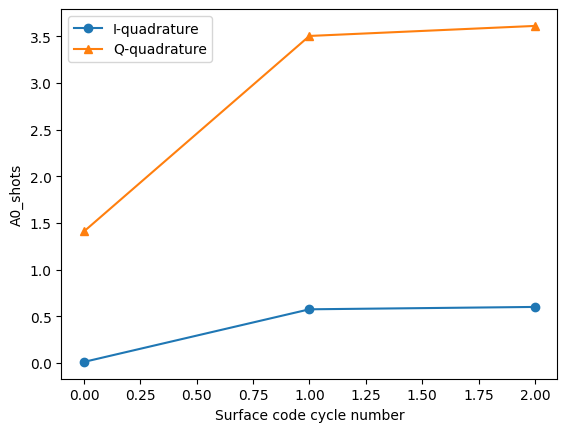

In [7]:
dataset_gridded.A0_shots.real.mean("repetitions").plot(marker="o", label="I-quadrature")
dataset_gridded.A0_shots.imag.mean("repetitions").plot(marker="^", label="Q-quadrature")
_ = plt.gca().legend()

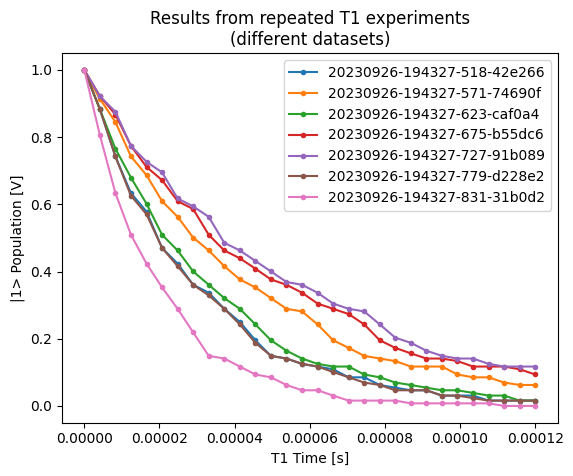

In [8]:
fig, ax = plt.subplots()
rng = np.random.default_rng(seed=112244)  # random number generator

num_t1_datasets = 7
t1_times = np.linspace(0, 120e-6, 30)

for tau in rng.uniform(10e-6, 50e-6, num_t1_datasets):
    probabilities = exp_decay_func(
        t=t1_times, tau=tau, offset=0, n_factor=1, amplitude=1
    )
    dataset = dataset_examples.mk_t1_av_with_cal_dataset(t1_times, probabilities)

    round_trip_dataset(dataset)  # confirm read/write
    dataset_g = dh.to_gridded_dataset(
        dataset, dimension="main_dim", coords_names=["t1_time"]
    )
    # rotate the iq data
    rotated_and_normalized = rotate_to_calibrated_axis(
        dataset_g.q0_iq_av.values, *dataset_g.q0_iq_av_cal.values
    )
    rotated_and_normalized_da = xr.DataArray(dataset_g.q0_iq_av)
    rotated_and_normalized_da.values = rotated_and_normalized
    rotated_and_normalized_da.attrs["long_name"] = "|1> Population"
    rotated_and_normalized_da.attrs["units"] = ""
    rotated_and_normalized_da.real.plot(ax=ax, label=dataset.tuid, marker=".")
ax.set_title("Results from repeated T1 experiments\n(different datasets)")
_ = ax.legend()

In [9]:
display_source_code(mk_nested_mc_dataset)

def mk_nested_mc_dataset ( 
 num_points : int = 12 , 
 flux_bias_min_max : tuple = ( - 0.04 , 0.04 ), 
 resonator_freqs_min_max : tuple = ( 7e9 , 7.3e9 ), 
 qubit_freqs_min_max : tuple = ( 4.5e9 , 5.0e9 ), 
 t1_values_min_max : tuple = ( 20e-6 , 50e-6 ), 
 seed : Optional [ int ] = 112233 , 
 ) -> xr . Dataset : 
 """ 
 Generates a dataset with dataset references and several coordinates that serve to 
 index the same variables. 

 Note that the each value for ``resonator_freqs``, ``qubit_freqs`` and ``t1_values`` 
 would have been extracted from other dataset corresponding to individual experiments 
 with their own dataset. 

 Parameters 
 ---------- 
 num_points 
 Number of datapoints to generate (used for all variables/coordinates). 
 flux_bias_min_max 
 Range for mock values. 
 resonator_freqs_min_max 
 Range for mock values. 
 qubit_freqs_min_max 
 Range for mock values. 
 t1_values_min_max 
 Range for mock random values. 
 seed 
 Random number generator seed passed to ``numpy.random.default_rng``. 
 """ 
 rng = np . random . default_rng ( seed = seed ) # random number generator 

 flux_bias_vals = np . linspace ( * flux_bias_min_max , num_points ) 
 resonator_freqs = np . linspace ( * resonator_freqs_min_max , num_points ) 
 qubit_freqs = np . linspace ( * qubit_freqs_min_max , num_points ) 
 t1_values = rng . uniform ( * t1_values_min_max , num_points ) 

 resonator_freq_tuids = [ dh . gen_tuid () for _ in range ( num_points )] 
 qubit_freq_tuids = [ dh . gen_tuid () for _ in range ( num_points )] 
 t1_tuids = [ dh . gen_tuid () for _ in range ( num_points )] 

 coords = dict ( 
 flux_bias = ( 
 "main_dim" , 
 flux_bias_vals , 
 mk_main_coord_attrs ( long_name = "Flux bias" , unit = "A" ), 
 ), 
 resonator_freq_tuids = ( 
 "main_dim" , 
 resonator_freq_tuids , 
 mk_main_coord_attrs ( 
 long_name = "Dataset TUID resonator frequency" , is_dataset_ref = True 
 ), 
 ), 
 qubit_freq_tuids = ( 
 "main_dim" , 
 qubit_freq_tuids , 
 mk_main_coord_attrs ( 
 long_name = "Dataset TUID qubit frequency" , is_dataset_ref = True 
 ), 
 ), 
 t1_tuids = ( 
 "main_dim" , 
 t1_tuids , 
 mk_main_coord_attrs ( long_name = "Dataset TUID T1" , is_dataset_ref = True ), 
 ), 
 ) 

 data_vars = dict ( 
 resonator_freq = ( 
 "main_dim" , 
 resonator_freqs , 
 mk_main_var_attrs ( long_name = "Resonator frequency" , unit = "Hz" ), 
 ), 
 qubit_freq = ( 
 "main_dim" , 
 qubit_freqs , 
 mk_main_var_attrs ( long_name = "Qubit frequency" , unit = "Hz" ), 
 ), 
 t1 = ( 
 "main_dim" , 
 t1_values , 
 mk_main_var_attrs ( long_name = "T1" , unit = "s" ), 
 ), 
 ) 
 dataset_attrs = mk_dataset_attrs () 

 dataset = xr . Dataset ( data_vars = data_vars , coords = coords , attrs = dataset_attrs ) 

 return dataset

In [10]:
dataset = mk_nested_mc_dataset(num_points=num_t1_datasets)
assert dataset == round_trip_dataset(dataset)  # confirm read/write
dataset

<xarray.Dataset>
Dimensions: (main_dim: 7)
Coordinates:
 flux_bias (main_dim) float64 -0.04 -0.02667 ... 0.02667 0.04
 resonator_freq_tuids (main_dim) <U26 '20230926-194328-153-9cd349' ... '2...
 qubit_freq_tuids (main_dim) <U26 '20230926-194328-153-890276' ... '2...
 t1_tuids (main_dim) <U26 '20230926-194328-153-8d4807' ... '2...
Dimensions without coordinates: main_dim
Data variables:
 resonator_freq (main_dim) float64 7e+09 7.05e+09 ... 7.25e+09 7.3e+09
 qubit_freq (main_dim) float64 4.5e+09 4.583e+09 ... 5e+09
 t1 (main_dim) float64 4.238e-05 3.867e-05 ... 4.154e-05
Attributes:
 tuid: 20230926-194328-154-79ecfe
 dataset_name: 
 dataset_state: None
 timestamp_start: None
 timestamp_end: None
 quantify_dataset_version: 2.0.0
 software_versions: {}
 relationships: []
 json_serialize_exclude: [] xarray.Dataset Dimensions: main_dim : 7 Coordinates: (4) flux_bias (main_dim) float64 -0.04 -0.02667 ... 0.02667 0.04 unit : A long_name : Flux bias is_main_coord : True uniformly_spaced : True is_dataset_ref : False json_serialize_exclude : [] array([-0.04 , -0.02666667, -0.01333333, 0. , 0.01333333,
 0.02666667, 0.04 ]) resonator_freq_tuids (main_dim) <U26 '20230926-194328-153-9cd349' ...... unit : long_name : Dataset TUID resonator frequency is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-9cd349', '20230926-194328-153-5c7e5b',
 '20230926-194328-153-10360a', '20230926-194328-153-f764a2',
 '20230926-194328-153-bcde38', '20230926-194328-153-5b301f',
 '20230926-194328-153-efc8ff'], dtype='<U26') qubit_freq_tuids (main_dim) <U26 '20230926-194328-153-890276' ...... unit : long_name : Dataset TUID qubit frequency is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-890276', '20230926-194328-153-103b10',
 '20230926-194328-153-7765a5', '20230926-194328-153-8b5174',
 '20230926-194328-153-495f5f', '20230926-194328-153-037098',
 '20230926-194328-153-21beb1'], dtype='<U26') t1_tuids (main_dim) <U26 '20230926-194328-153-8d4807' ...... unit : long_name : Dataset TUID T1 is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-8d4807', '20230926-194328-153-1c6d16',
 '20230926-194328-153-ef9cab', '20230926-194328-153-fac5b4',
 '20230926-194328-153-be7657', '20230926-194328-153-8e6fc5',
 '20230926-194328-154-fc7e41'], dtype='<U26') Data variables: (3) resonator_freq (main_dim) float64 7e+09 7.05e+09 ... 7.25e+09 7.3e+09 unit : Hz long_name : Resonator frequency is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : False json_serialize_exclude : [] array([7.00e+09, 7.05e+09, 7.10e+09, 7.15e+09, 7.20e+09, 7.25e+09,
 7.30e+09]) qubit_freq (main_dim) float64 4.5e+09 4.583e+09 ... 5e+09 unit : Hz long_name : Qubit frequency is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : False json_serialize_exclude : [] array([4.50000000e+09, 4.58333333e+09, 4.66666667e+09, 4.75000000e+09,
 4.83333333e+09, 4.91666667e+09, 5.00000000e+09]) t1 (main_dim) float64 4.238e-05 3.867e-05 ... 4.154e-05 unit : s long_name : T1 is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : False json_serialize_exclude : [] array([4.23844928e-05, 3.86705687e-05, 3.70527085e-05, 3.48700378e-05,
 2.23892678e-05, 2.82835896e-05, 4.15363657e-05]) Attributes: (9) tuid : 20230926-194328-154-79ecfe dataset_name : dataset_state : None timestamp_start : None timestamp_end : None quantify_dataset_version : 2.0.0 software_versions : {} relationships : [] json_serialize_exclude : []

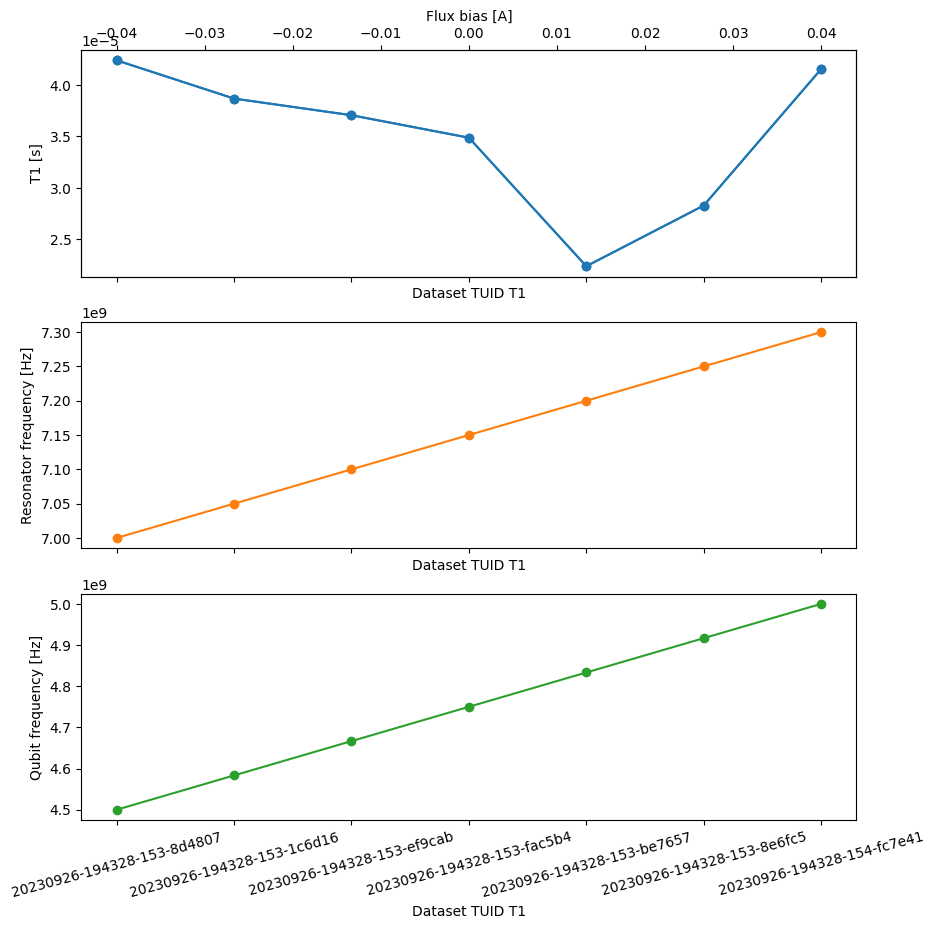

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

_ = dataset.t1.plot(x="flux_bias", marker="o", ax=axs[0].twiny(), color="C0")
x = "t1_tuids"
_ = dataset.t1.plot(x=x, marker="o", ax=axs[0], color="C0")
_ = dataset.resonator_freq.plot(x=x, marker="o", ax=axs[1], color="C1")
_ = dataset.qubit_freq.plot(x=x, marker="o", ax=axs[2], color="C2")
for tick in axs[2].get_xticklabels():
    tick.set_rotation(15)  # avoid tuid labels overlapping

In [12]:
dataset_multi_indexed = dataset.set_index({"main_dim": tuple(dataset.t1.coords.keys())})
dataset_multi_indexed

<xarray.Dataset>
Dimensions: (main_dim: 7)
Coordinates:
 * main_dim (main_dim) object MultiIndex
 * flux_bias (main_dim) float64 -0.04 -0.02667 ... 0.02667 0.04
 * resonator_freq_tuids (main_dim) <U26 '20230926-194328-153-9cd349' ... '2...
 * qubit_freq_tuids (main_dim) <U26 '20230926-194328-153-890276' ... '2...
 * t1_tuids (main_dim) <U26 '20230926-194328-153-8d4807' ... '2...
Data variables:
 resonator_freq (main_dim) float64 7e+09 7.05e+09 ... 7.25e+09 7.3e+09
 qubit_freq (main_dim) float64 4.5e+09 4.583e+09 ... 5e+09
 t1 (main_dim) float64 4.238e-05 3.867e-05 ... 4.154e-05
Attributes:
 tuid: 20230926-194328-154-79ecfe
 dataset_name: 
 dataset_state: None
 timestamp_start: None
 timestamp_end: None
 quantify_dataset_version: 2.0.0
 software_versions: {}
 relationships: []
 json_serialize_exclude: [] xarray.Dataset Dimensions: main_dim : 7 Coordinates: (5) main_dim (main_dim) object MultiIndex array([(-0.04, '20230926-194328-153-9cd349', '20230926-194328-153-890276', '20230926-194328-153-8d4807'),
 (-0.026666666666666665, '20230926-194328-153-5c7e5b', '20230926-194328-153-103b10', '20230926-194328-153-1c6d16'),
 (-0.013333333333333332, '20230926-194328-153-10360a', '20230926-194328-153-7765a5', '20230926-194328-153-ef9cab'),
 (0.0, '20230926-194328-153-f764a2', '20230926-194328-153-8b5174', '20230926-194328-153-fac5b4'),
 (0.013333333333333336, '20230926-194328-153-bcde38', '20230926-194328-153-495f5f', '20230926-194328-153-be7657'),
 (0.026666666666666665, '20230926-194328-153-5b301f', '20230926-194328-153-037098', '20230926-194328-153-8e6fc5'),
 (0.04, '20230926-194328-153-efc8ff', '20230926-194328-153-21beb1', '20230926-194328-154-fc7e41')],
 dtype=object) flux_bias (main_dim) float64 -0.04 -0.02667 ... 0.02667 0.04 unit : A long_name : Flux bias is_main_coord : True uniformly_spaced : True is_dataset_ref : False json_serialize_exclude : [] array([-0.04 , -0.026667, -0.013333, 0. , 0.013333, 0.026667,
 0.04 ]) resonator_freq_tuids (main_dim) <U26 '20230926-194328-153-9cd349' ...... unit : long_name : Dataset TUID resonator frequency is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-9cd349', '20230926-194328-153-5c7e5b',
 '20230926-194328-153-10360a', '20230926-194328-153-f764a2',
 '20230926-194328-153-bcde38', '20230926-194328-153-5b301f',
 '20230926-194328-153-efc8ff'], dtype=object) qubit_freq_tuids (main_dim) <U26 '20230926-194328-153-890276' ...... unit : long_name : Dataset TUID qubit frequency is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-890276', '20230926-194328-153-103b10',
 '20230926-194328-153-7765a5', '20230926-194328-153-8b5174',
 '20230926-194328-153-495f5f', '20230926-194328-153-037098',
 '20230926-194328-153-21beb1'], dtype=object) t1_tuids (main_dim) <U26 '20230926-194328-153-8d4807' ...... unit : long_name : Dataset TUID T1 is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-8d4807', '20230926-194328-153-1c6d16',
 '20230926-194328-153-ef9cab', '20230926-194328-153-fac5b4',
 '20230926-194328-153-be7657', '20230926-194328-153-8e6fc5',
 '20230926-194328-154-fc7e41'], dtype=object) Data variables: (3) resonator_freq (main_dim) float64 7e+09 7.05e+09 ... 7.25e+09 7.3e+09 unit : Hz long_name : Resonator frequency is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : False json_serialize_exclude : [] array([7.00e+09, 7.05e+09, 7.10e+09, 7.15e+09, 7.20e+09, 7.25e+09,
 7.30e+09]) qubit_freq (main_dim) float64 4.5e+09 4.583e+09 ... 5e+09 unit : Hz long_name : Qubit frequency is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : False json_serialize_exclude : [] array([4.50000000e+09, 4.58333333e+09, 4.66666667e+09, 4.75000000e+09,
 4.83333333e+09, 4.91666667e+09, 5.00000000e+09]) t1 (main_dim) float64 4.238e-05 3.

In [13]:
index = 2
dataset_multi_indexed.qubit_freq.sel(
    qubit_freq_tuids=dataset_multi_indexed.qubit_freq_tuids.values[index]
)

<xarray.DataArray 'qubit_freq' (main_dim: 1)>
array([4.66666667e+09])
Coordinates:
 * main_dim (main_dim) object MultiIndex
 * flux_bias (main_dim) float64 -0.01333
 * resonator_freq_tuids (main_dim) <U26 '20230926-194328-153-10360a'
 * t1_tuids (main_dim) <U26 '20230926-194328-153-ef9cab'
 qubit_freq_tuids <U26 '20230926-194328-153-7765a5'
Attributes:
 unit: Hz
 long_name: Qubit frequency
 is_main_var: True
 uniformly_spaced: True
 grid: True
 is_dataset_ref: False
 has_repetitions: False
 json_serialize_exclude: [] xarray.DataArray 'qubit_freq' main_dim : 1 4.667e+09 array([4.66666667e+09]) Coordinates: (5) main_dim (main_dim) object MultiIndex array([(-0.013333333333333332, '20230926-194328-153-10360a', '20230926-194328-153-ef9cab')],
 dtype=object) flux_bias (main_dim) float64 -0.01333 unit : A long_name : Flux bias is_main_coord : True uniformly_spaced : True is_dataset_ref : False json_serialize_exclude : [] array([-0.013333]) resonator_freq_tuids (main_dim) <U26 '20230926-194328-153-10360a' unit : long_name : Dataset TUID resonator frequency is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-10360a'], dtype=object) t1_tuids (main_dim) <U26 '20230926-194328-153-ef9cab' unit : long_name : Dataset TUID T1 is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-ef9cab'], dtype=object) qubit_freq_tuids () <U26 '20230926-194328-153-7765a5' unit : long_name : Dataset TUID qubit frequency is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array('20230926-194328-153-7765a5', dtype='<U26') Attributes: (8) unit : Hz long_name : Qubit frequency is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : False json_serialize_exclude : []

In [14]:
dataset_multi_indexed.qubit_freq.sel(t1_tuids=dataset.t1_tuids.values[index])

<xarray.DataArray 'qubit_freq' (main_dim: 1)>
array([4.66666667e+09])
Coordinates:
 * main_dim (main_dim) object MultiIndex
 * flux_bias (main_dim) float64 -0.01333
 * resonator_freq_tuids (main_dim) <U26 '20230926-194328-153-10360a'
 * qubit_freq_tuids (main_dim) <U26 '20230926-194328-153-7765a5'
 t1_tuids <U26 '20230926-194328-153-ef9cab'
Attributes:
 unit: Hz
 long_name: Qubit frequency
 is_main_var: True
 uniformly_spaced: True
 grid: True
 is_dataset_ref: False
 has_repetitions: False
 json_serialize_exclude: [] xarray.DataArray 'qubit_freq' main_dim : 1 4.667e+09 array([4.66666667e+09]) Coordinates: (5) main_dim (main_dim) object MultiIndex array([(-0.013333333333333332, '20230926-194328-153-10360a', '20230926-194328-153-7765a5')],
 dtype=object) flux_bias (main_dim) float64 -0.01333 unit : A long_name : Flux bias is_main_coord : True uniformly_spaced : True is_dataset_ref : False json_serialize_exclude : [] array([-0.013333]) resonator_freq_tuids (main_dim) <U26 '20230926-194328-153-10360a' unit : long_name : Dataset TUID resonator frequency is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-10360a'], dtype=object) qubit_freq_tuids (main_dim) <U26 '20230926-194328-153-7765a5' unit : long_name : Dataset TUID qubit frequency is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-7765a5'], dtype=object) t1_tuids () <U26 '20230926-194328-153-ef9cab' unit : long_name : Dataset TUID T1 is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array('20230926-194328-153-ef9cab', dtype='<U26') Attributes: (8) unit : Hz long_name : Qubit frequency is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : False json_serialize_exclude : []

In [15]:
try:
    assert dataset_multi_indexed == round_trip_dataset(dataset_multi_indexed)
except NotImplementedError as exp:
    print(exp)

variable 'main_dim' is a MultiIndex, which cannot yet be serialized to netCDF files (https://github.com/pydata/xarray/issues/1077). Use reset_index() to convert MultiIndex levels into coordinate variables instead.


In [16]:
dataset_multi_indexed.reset_index(dims_or_levels="main_dim")

<xarray.Dataset>
Dimensions: (main_dim: 7)
Coordinates:
 main_dim (main_dim) object MultiIndex
 flux_bias (main_dim) float64 -0.04 -0.02667 ... 0.02667 0.04
 resonator_freq_tuids (main_dim) <U26 '20230926-194328-153-9cd349' ... '2...
 qubit_freq_tuids (main_dim) <U26 '20230926-194328-153-890276' ... '2...
 t1_tuids (main_dim) <U26 '20230926-194328-153-8d4807' ... '2...
Data variables:
 resonator_freq (main_dim) float64 7e+09 7.05e+09 ... 7.25e+09 7.3e+09
 qubit_freq (main_dim) float64 4.5e+09 4.583e+09 ... 5e+09
 t1 (main_dim) float64 4.238e-05 3.867e-05 ... 4.154e-05
Attributes:
 tuid: 20230926-194328-154-79ecfe
 dataset_name: 
 dataset_state: None
 timestamp_start: None
 timestamp_end: None
 quantify_dataset_version: 2.0.0
 software_versions: {}
 relationships: []
 json_serialize_exclude: [] xarray.Dataset Dimensions: main_dim : 7 Coordinates: (5) main_dim (main_dim) object MultiIndex array([(-0.04, '20230926-194328-153-9cd349', '20230926-194328-153-890276', '20230926-194328-153-8d4807'),
 (-0.026666666666666665, '20230926-194328-153-5c7e5b', '20230926-194328-153-103b10', '20230926-194328-153-1c6d16'),
 (-0.013333333333333332, '20230926-194328-153-10360a', '20230926-194328-153-7765a5', '20230926-194328-153-ef9cab'),
 (0.0, '20230926-194328-153-f764a2', '20230926-194328-153-8b5174', '20230926-194328-153-fac5b4'),
 (0.013333333333333336, '20230926-194328-153-bcde38', '20230926-194328-153-495f5f', '20230926-194328-153-be7657'),
 (0.026666666666666665, '20230926-194328-153-5b301f', '20230926-194328-153-037098', '20230926-194328-153-8e6fc5'),
 (0.04, '20230926-194328-153-efc8ff', '20230926-194328-153-21beb1', '20230926-194328-154-fc7e41')],
 dtype=object) flux_bias (main_dim) float64 -0.04 -0.02667 ... 0.02667 0.04 unit : A long_name : Flux bias is_main_coord : True uniformly_spaced : True is_dataset_ref : False json_serialize_exclude : [] array([-0.04 , -0.026667, -0.013333, 0. , 0.013333, 0.026667,
 0.04 ]) resonator_freq_tuids (main_dim) <U26 '20230926-194328-153-9cd349' ...... unit : long_name : Dataset TUID resonator frequency is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-9cd349', '20230926-194328-153-5c7e5b',
 '20230926-194328-153-10360a', '20230926-194328-153-f764a2',
 '20230926-194328-153-bcde38', '20230926-194328-153-5b301f',
 '20230926-194328-153-efc8ff'], dtype=object) qubit_freq_tuids (main_dim) <U26 '20230926-194328-153-890276' ...... unit : long_name : Dataset TUID qubit frequency is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-890276', '20230926-194328-153-103b10',
 '20230926-194328-153-7765a5', '20230926-194328-153-8b5174',
 '20230926-194328-153-495f5f', '20230926-194328-153-037098',
 '20230926-194328-153-21beb1'], dtype=object) t1_tuids (main_dim) <U26 '20230926-194328-153-8d4807' ...... unit : long_name : Dataset TUID T1 is_main_coord : True uniformly_spaced : True is_dataset_ref : True json_serialize_exclude : [] array(['20230926-194328-153-8d4807', '20230926-194328-153-1c6d16',
 '20230926-194328-153-ef9cab', '20230926-194328-153-fac5b4',
 '20230926-194328-153-be7657', '20230926-194328-153-8e6fc5',
 '20230926-194328-154-fc7e41'], dtype=object) Data variables: (3) resonator_freq (main_dim) float64 7e+09 7.05e+09 ... 7.25e+09 7.3e+09 unit : Hz long_name : Resonator frequency is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : False json_serialize_exclude : [] array([7.00e+09, 7.05e+09, 7.10e+09, 7.15e+09, 7.20e+09, 7.25e+09,
 7.30e+09]) qubit_freq (main_dim) float64 4.5e+09 4.583e+09 ... 5e+09 unit : Hz long_name : Qubit frequency is_main_var : True uniformly_spaced : True grid : True is_dataset_ref : False has_repetitions : False json_serialize_exclude : [] array([4.50000000e+09, 4.58333333e+09, 4.66666667e+09, 4.75000000e+09,
 4.83333333e+09, 4.91666667e+09, 5.00000000e+09]) t1 (main_dim) float64 4.238e-05 3.867e-05 ..

In [17]:
all(dataset_multi_indexed.reset_index("main_dim").t1_tuids == dataset.t1_tuids)

True

In [18]:
dataset.t1_tuids.dtype, dataset_multi_indexed.reset_index("main_dim").t1_tuids.dtype

(dtype('<U26'), dtype('<U26'))

In [19]:
dataset.t1_tuids.dtype == dataset_multi_indexed.reset_index("main_dim").t1_tuids.dtype

True